# <center>Performance evaluation of Terapixel rendering in Cloud (Super)computing</center>
<center>Submittive Assignment</center>
<br>
<center><em>Rishabh Malik(220512619)</em></center>

---


## 1. Introduction

Terapixel images, which are composed of a vast number of pixels, can present information to stakeholders in an effective manner, but they require a high amount of computational power. To reduce costs and optimize the process, it's useful to use cloud-based supercomputing resources to process the data collected during the creation of a terapixel image of Newcastle Upon Tyne. The issue at hand is how to access the necessary supercomputing resources for the calculation of this large-scale image in the cloud. The objective is to analyze the data from the application checkpoint and system metric output to improve the cost-efficiency of the process.

## 2. Business Understanding

The business understanding phase focuses on understanding the requirement from the business perspective of the project.This is an important aspect of business for this project as it helps organizations understand the capabilities and limitations of their cloud-based supercomputing infrastructure in handling large-scale image rendering tasks.

This information can be used to make informed decisions about the use of cloud computing resources for large-scale image rendering, such as whether to invest in additional resources or optimize existing ones. Additionally, it can also help organizations to identify bottlenecks in their workflow and make adjustments to improve the performance and cost-efficiency of the process.

Furthermore, the performance evaluation can also be used to compare the performance of different cloud providers or different configurations, which can be useful for organizations to choose the best solution for their specific needs. In short this helps organizations to optimize their cloud-based supercomputing infrastructure to handle large-scale image rendering tasks efficiently, make informed decisions about the use of cloud resources, and improve the overall performance and cost-efficiency of the process.

Through this analysis we will gain insights on the following:
- Which event types dominate task runtimes?
- What is the interplay between GPU temperature and performance?
- What is the interplay between increased power draw and render time?
- Can we identify particular GPU cards (based on their serial numbers) whose performance differs to other cards? (i.e. perpetually slow cards).


## 3. Data Understanding

Adding to the foundation of Business Understanding, it drives the focus to identify, collect, and analyze the data sets that can help you accomplish the project goals. Here we acquire the necessary data and load it into our analysis tool and get a field overview of the dataset and its format, number of records, and other fields.

The data presented in this report was obtained from an experiment that employed a massive 1024 GPU setup. The rendering process was broken down into three distinct levels, specifically, levels 4, 8 and 12 of the final output. The information provided in the dataset gives an in-depth insight into the timing of the rendering performance, the performance of the GPU and the exact area of the image that was being handled during each job.

Our data consist of three files:
- *application-checkpoint.csv*
- *gpu.csv*
- *task-x-y.csv*  


- **application-checkpoint.csv:** this file contains information on the various events that occurred during the rendering process, including the type of event, the timestamp it occurred, and the hostname, taskId, and jobId associated with it.

 - **timestamp:** this column records the precise moment the event began or ended.
 - **hostname:** this column lists the 1024 unique GPUs used in the operation. 
 - **eventName:** this column includes 5 different types of events: Tiling, Render, Saving Config, Uploading, and TotalRender.  
 
   - **TotalRender:** this represents the overall task.
   - **Render:** this is when specific tiles of the image are being rendered.
   - **Tiling:** is the post-processing of the rendered tiles.
   - **Saving Config:** is when the specific configurations for each task are saved
   - **Uploading:** is when the post-processed tiles are uploaded to Azure Blob Storage.
   
 - **eventType:** this column indicates whether the event is starting or ending
 - **jobId:** this column indicates the specific level of the visualization output (level 12, level 8, and level 4)
 - **taskId:** this column providing a unique identification for each set of events, including their start and stop timestamps. There will be n/10 unique taskIds in the file, where n is the number of rows in the application-checkpoint.csv.  
 
 
- **gpu.csv:** this file contains information about the status of the graphics processing units (GPUs) at a specific point in time. 

 - **gpuSerial:** this file includes details such as the unique serial number for each of the 1024 GPUs.
 - **gpuUUID:** this is the system-assigned unique identifier for each GPU.
 - **powerDrawWatt:** the amount of power being used by the GPU in watts.
 - **gpuTempC:** the temperature of the GPU in degrees Celsius
 - **gpuUtilPerc:** the percentage of the GPU's cores that are being used.
 - **gpuMemUtilPerc:** the percentage of the GPU's memory that is being utilized.  
 
 
- **task-x-y.csv:** this file contains information about the specific sections of an image that are being rendered.
 - **x and y:** it includes the x and y coordinates of the tiles being processed.
 - **level:** this is the level of zoom being used. The visualization is designed to be similar to a "google maps style" map, with 12 levels of zoom available. The data only includes levels 4, 8, and 12, as the intermediate levels are created during the post-processing, or tiling, phase. 

## 4. Data Processing

This phase is also called as data munging. Here we will now merge the 3 data files into one to make some meaningful dataset.

- Firstly left join the 2 data files *task-x-y.csv* and *application-checkpoint.csv* based on two columns *jobId* and *taskId*.
- Secondly inner join the *gpu.csv* file with the data from the previous step based on column *timestamp*.

Now on the final datafile data cleaning is to be performed, as there are some duplicate values and we can see that the timestamp column is not in the proper format. Hence we delete the duplicates in the final datafile.
Also we use the *datetime* library to format the timestamp column to make it standard time for further calculations.

As we have already understood in the Business Understanding phase that we need to calculate the duration of the events, hence we need to perform munge on the timestamp column. Now we create 2 data frames **df_start** and **df_stop**. For the *df_start* we take the eventType = 'START' and put the timestamp in the as *start_time* and similarly for eventType = 'STOP' we put the timestamp in *stop_time*.
Merged start and stop dataframes of respective events on taskId and then substract start and stop time to compute the duration and store it in a 'duration' column. Now the final merged dataset has the duration time as well for further compuatations.


In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from matplotlib import pyplot
from pandas import Series
import statistics
from datetime import datetime as dt, date 
from dateutil import parser

In [40]:
gpudf = pd.read_csv('gpu.csv')
appdf = pd.read_csv('application_checkpoints.csv')
taskdf = pd.read_csv('task-x-y.csv')

In [41]:
app_task_df = pd.merge(taskdf, appdf, on = ['jobId','taskId'], how='left')
app_task_gpu_df = pd.merge(app_task_df, gpudf, on = ['timestamp'])

In [43]:
app_task_gpu_df.head()

,taskId,jobId,x,y,level,timestamp,hostname_x,eventName,eventType,hostname_y,gpuSerial,gpuUUID,powerDrawWatt,gpuTempC,gpuUtilPerc,gpuMemUtilPerc
0,00004e77-304c-4fbd-88a1-1346ef947567,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,116,178,12,2018-11-08T08:07:10.688Z,0745914f4de046078517041d70b22fe7000001,Tiling,STOP,265232c5f6814768aeefa66a7bec6ff600000Q,323617020812,GPU-f8ed40fb-e2c2-d6e2-9a66-4b6eaae14912,125.89,39,92,60
1,00004e77-304c-4fbd-88a1-1346ef947567,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,116,178,12,2018-11-08T08:07:10.688Z,0745914f4de046078517041d70b22fe7000001,Tiling,STOP,0d56a730076643d585f77e00d2d8521a00000Q,325117171574,GPU-d84a1024-9381-c725-3b85-dd7143e64c35,25.91,33,0,0
2,0002afb5-d05e-4da9-bd53-7b6dc19ea6d4,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,142,190,12,2018-11-08T08:14:48.855Z,83ea61ac1ef54f27a3bf7bd0f41ecaa700001A,Uploading,START,d8241877cd994572b46c861e5d144c8500000W,323617021323,GPU-f5716e40-9e60-f0af-7a7a-95d2fc4d2fd9,102.36,41,92,52
3,0002afb5-d05e-4da9-bd53-7b6dc19ea6d4,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,142,190,12,2018-11-08T08:14:48.855Z,83ea61ac1ef54f27a3bf7bd0f41ecaa700001A,Render,STOP,d8241877cd994572b46c861e5d144c8500000W,323617021323,GPU-f5716e40-9e60-f0af-7a7a-95d2fc4d2fd9,102.36,41,92,52
4,0002afb5-d05e-4da9-bd53-7b6dc19ea6d4,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,142,190,12,2018-11-08T08:14:49.863Z,83ea61ac1ef54f27a3bf7bd0f41ecaa700001A,TotalRender,STOP,8b6a0eebc87b4cb2b0539e81075191b900000U,323617021463,GPU-f955049b-a429-3eed-f7f1-30a072341123,136.61,49,94,55


In [45]:
app_task_gpu_df.shape

(337690, 16)

In [47]:
app_task_gpu_df = app_task_gpu_df.drop_duplicates(subset=None, keep='first', inplace=False)# deleting duplicate rows...

In [48]:
app_task_gpu_df.shape

(336488, 16)

In [53]:
app_task_gpu_df["time"] = app_task_gpu_df["timestamp"].apply(lambda x: parser.isoparse(x)) # extracting only time part of the timestamp column and storing it in "time" column...

/var/folders/t_/yqp01jbs4hqd74l2lcbjvbb80000gn/T/ipykernel_68421/930291541.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app_task_gpu_df["time"] = app_task_gpu_df["timestamp"].apply(lambda x: parser.isoparse(x)) # extracting only time part of the timestamp column and storing it in "time" column...


In [50]:
app_task_gpu_df.head()

,taskId,jobId,x,y,level,timestamp,hostname_x,eventName,eventType,hostname_y,gpuSerial,gpuUUID,powerDrawWatt,gpuTempC,gpuUtilPerc,gpuMemUtilPerc,time
0,00004e77-304c-4fbd-88a1-1346ef947567,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,116,178,12,2018-11-08T08:07:10.688Z,0745914f4de046078517041d70b22fe7000001,Tiling,STOP,265232c5f6814768aeefa66a7bec6ff600000Q,323617020812,GPU-f8ed40fb-e2c2-d6e2-9a66-4b6eaae14912,125.89,39,92,60,2018-11-08 08:07:10.688000+00:00
1,00004e77-304c-4fbd-88a1-1346ef947567,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,116,178,12,2018-11-08T08:07:10.688Z,0745914f4de046078517041d70b22fe7000001,Tiling,STOP,0d56a730076643d585f77e00d2d8521a00000Q,325117171574,GPU-d84a1024-9381-c725-3b85-dd7143e64c35,25.91,33,0,0,2018-11-08 08:07:10.688000+00:00
2,0002afb5-d05e-4da9-bd53-7b6dc19ea6d4,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,142,190,12,2018-11-08T08:14:48.855Z,83ea61ac1ef54f27a3bf7bd0f41ecaa700001A,Uploading,START,d8241877cd994572b46c861e5d144c8500000W,323617021323,GPU-f5716e40-9e60-f0af-7a7a-95d2fc4d2fd9,102.36,41,92,52,2018-11-08 08:14:48.855000+00:00
3,0002afb5-d05e-4da9-bd53-7b6dc19ea6d4,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,142,190,12,2018-11-08T08:14:48.855Z,83ea61ac1ef54f27a3bf7bd0f41ecaa700001A,Render,STOP,d8241877cd994572b46c861e5d144c8500000W,323617021323,GPU-f5716e40-9e60-f0af-7a7a-95d2fc4d2fd9,102.36,41,92,52,2018-11-08 08:14:48.855000+00:00
4,0002afb5-d05e-4da9-bd53-7b6dc19ea6d4,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,142,190,12,2018-11-08T08:14:49.863Z,83ea61ac1ef54f27a3bf7bd0f41ecaa700001A,TotalRender,STOP,8b6a0eebc87b4cb2b0539e81075191b900000U,323617021463,GPU-f955049b-a429-3eed-f7f1-30a072341123,136.61,49,94,55,2018-11-08 08:14:49.863000+00:00


In [52]:
df_start = app_task_gpu_df[app_task_gpu_df['eventType'] == 'START']
df_stop = app_task_gpu_df[app_task_gpu_df['eventType'] == 'STOP']

df_start = df_start.rename(columns={"timestamp": "start_time"})
df_stop = df_stop.rename(columns={"timestamp": "stop_time"})

df_start = df_start.drop('eventType', axis = 1)
df_stop = df_stop.drop('eventType', axis = 1)

# convert columns to datetime
df_start["start_time"] = pd.to_datetime(df_start["start_time"])
df_stop["stop_time"] = pd.to_datetime(df_stop["stop_time"])

df = pd.merge(df_start, df_stop, on=['eventName', 'x', 'y', 'level'])

# calculate duration
df['duration'] = (df['stop_time'] - df['start_time']).dt.total_seconds()
df

,taskId_x,jobId_x,x,y,level,start_time,hostname_x_x,eventName,hostname_y_x,gpuSerial_x,...,hostname_x_y,hostname_y_y,gpuSerial_y,gpuUUID_y,powerDrawWatt_y,gpuTempC_y,gpuUtilPerc_y,gpuMemUtilPerc_y,time_y,duration
0,0002afb5-d05e-4da9-bd53-7b6dc19ea6d4,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,142,190,12,2018-11-08 08:14:48.855000+00:00,83ea61ac1ef54f27a3bf7bd0f41ecaa700001A,Uploading,d8241877cd994572b46c861e5d144c8500000W,323617021323,...,83ea61ac1ef54f27a3bf7bd0f41ecaa700001A,8b6a0eebc87b4cb2b0539e81075191b900000U,323617021463,GPU-f955049b-a429-3eed-f7f1-30a072341123,136.61,49,94,55,2018-11-08 08:14:49.863000+00:00,1.008
1,0003c380-4db9-49fb-8e1c-6f8ae466ad85,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,142,86,12,2018-11-08 07:49:17.082000+00:00,83ea61ac1ef54f27a3bf7bd0f41ecaa7000004,Tiling,0745914f4de046078517041d70b22fe7000014,325117064385,...,83ea61ac1ef54f27a3bf7bd0f41ecaa7000004,4ad946d4435c42dabb5073531ea4f31500000Y,320218055700,GPU-a2836c0d-5c10-eff0-4910-9681b4b039a7,128.23,37,93,57,2018-11-08 07:49:18.028000+00:00,0.946
2,0003c380-4db9-49fb-8e1c-6f8ae466ad85,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,142,86,12,2018-11-08 07:49:17.082000+00:00,83ea61ac1ef54f27a3bf7bd0f41ecaa7000004,Tiling,8b6a0eebc87b4cb2b0539e81075191b900000T,323617021011,...,83ea61ac1ef54f27a3bf7bd0f41ecaa7000004,4ad946d4435c42dabb5073531ea4f31500000Y,320218055700,GPU-a2836c0d-5c10-eff0-4910-9681b4b039a7,128.23,37,93,57,2018-11-08 07:49:18.028000+00:00,0.946
3,0003c380-4db9-49fb-8e1c-6f8ae466ad85,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,142,86,12,2018-11-08 07:49:17.082000+00:00,83ea61ac1ef54f27a3bf7bd0f41ecaa7000004,Tiling,265232c5f6814768aeefa66a7bec6ff600000T,323617020801,...,83ea61ac1ef54f27a3bf7bd0f41ecaa7000004,4ad946d4435c42dabb5073531ea4f31500000Y,320218055700,GPU-a2836c0d-5c10-eff0-4910-9681b4b039a7,128.23,37,93,57,2018-11-08 07:49:18.028000+00:00,0.946
4,000d1def-1478-40d3-a5e3-4f848daee474,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,179,226,12,2018-11-08 08:21:27.481000+00:00,b9a1fa7ae2f74eb68f25f607980f97d700000V,Tiling,b9a1fa7ae2f74eb68f25f607980f97d7000019,324917052134,...,b9a1fa7ae2f74eb68f25f607980f97d700000V,4ad946d4435c42dabb5073531ea4f315000018,325017018095,GPU-6ab2031f-938b-3d9a-fc14-9c9e308d2716,118.93,40,91,46,2018-11-08 08:21:28.583000+00:00,1.102
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85800,ecb08d02-79b5-43ef-b58c-b55b4b84e39c,1024-lvl8-5ad819e1-fbf2-42e0-8f16-a3baca825a63,12,4,8,2018-11-08 07:42:39.161000+00:00,83ea61ac1ef54f27a3bf7bd0f41ecaa700000J,Uploading,8b6a0eebc87b4cb2b0539e81075191b900001D,323617021151,...,83ea61ac1ef54f27a3bf7bd0f41ecaa700000J,265232c5f6814768aeefa66a7bec6ff6000010,323617020951,GPU-af3d11cb-8a8c-1d21-2906-216f0a3e55ad,34.37,34,1,0,2018-11-08 07:42:40.187000+00:00,1.026
85801,f7b53cc0-d2f1-421b-a7a1-4949ddc38075,1024-lvl8-5ad819e1-fbf2-42e0-8f16-a3baca825a63,2,6,8,2018-11-08 07:42:50.906000+00:00,cd44f5819eba427a816e7ce648adceb2000001,Uploading,265232c5f6814768aeefa66a7bec6ff6000001,323217056104,...,cd44f5819eba427a816e7ce648adceb2000001,a77ef58b13ad4c01b769dac8409af3f800000X,323617020586,GPU-9c0266e2-aa48-361b-455e-f5fc6159ee31,83.40,35,82,34,2018-11-08 07:42:51.970000+00:00,1.064
85802,f8559617-7298-4ee0-9742-9e9e7b5f54df,1024-lvl8-5ad819e1-fbf2-42e0-8f16-a3baca825a63,14,3,8,2018-11-08 07:43:14.194000+00:00,0d56a730076643d585f77e00d2d8521a00000R,Tiling,6139a35676de44d6b61ec247f0ed8657000018,325017018337,...,0d56a730076643d585f77e00d2d8521a00000R,83ea61ac1ef54f27a3bf7bd0f41ecaa700000X,323617043082,GPU-88356e9f-7159-3ed6-b131-c4bfc506e7e9,94.95,43,89,44,2018-11-08 07:43:15.317000+00:00,1.123
85803,fb9f46a2-a940-4773-996f-6db2204350d2,1024-lvl8-5ad819e1-fbf2-42e0-8f16-a3baca825a63,0,0,8,2018-11-08 07:42:13.045000+00:00,04dc4e9647154250beeee51b866b071500000X,Uploading,04dc4e9647154250beeee51b866b071500000T,323217056004,...,04dc4e9647154250beeee51b866b071500000X,b9a1fa7ae2f74eb68f25f607980f97d700001A,325017017862,GPU-7788192a-b813

In [56]:
df.head()

,taskId_x,jobId_x,x,y,level,start_time,hostname_x_x,eventName,hostname_y_x,gpuSerial_x,...,hostname_x_y,hostname_y_y,gpuSerial_y,gpuUUID_y,powerDrawWatt_y,gpuTempC_y,gpuUtilPerc_y,gpuMemUtilPerc_y,time_y,duration
0,0002afb5-d05e-4da9-bd53-7b6dc19ea6d4,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,142,190,12,2018-11-08 08:14:48.855000+00:00,83ea61ac1ef54f27a3bf7bd0f41ecaa700001A,Uploading,d8241877cd994572b46c861e5d144c8500000W,323617021323,...,83ea61ac1ef54f27a3bf7bd0f41ecaa700001A,8b6a0eebc87b4cb2b0539e81075191b900000U,323617021463,GPU-f955049b-a429-3eed-f7f1-30a072341123,136.61,49,94,55,2018-11-08 08:14:49.863000+00:00,1.008
1,0003c380-4db9-49fb-8e1c-6f8ae466ad85,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,142,86,12,2018-11-08 07:49:17.082000+00:00,83ea61ac1ef54f27a3bf7bd0f41ecaa7000004,Tiling,0745914f4de046078517041d70b22fe7000014,325117064385,...,83ea61ac1ef54f27a3bf7bd0f41ecaa7000004,4ad946d4435c42dabb5073531ea4f31500000Y,320218055700,GPU-a2836c0d-5c10-eff0-4910-9681b4b039a7,128.23,37,93,57,2018-11-08 07:49:18.028000+00:00,0.946
2,0003c380-4db9-49fb-8e1c-6f8ae466ad85,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,142,86,12,2018-11-08 07:49:17.082000+00:00,83ea61ac1ef54f27a3bf7bd0f41ecaa7000004,Tiling,8b6a0eebc87b4cb2b0539e81075191b900000T,323617021011,...,83ea61ac1ef54f27a3bf7bd0f41ecaa7000004,4ad946d4435c42dabb5073531ea4f31500000Y,320218055700,GPU-a2836c0d-5c10-eff0-4910-9681b4b039a7,128.23,37,93,57,2018-11-08 07:49:18.028000+00:00,0.946
3,0003c380-4db9-49fb-8e1c-6f8ae466ad85,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,142,86,12,2018-11-08 07:49:17.082000+00:00,83ea61ac1ef54f27a3bf7bd0f41ecaa7000004,Tiling,265232c5f6814768aeefa66a7bec6ff600000T,323617020801,...,83ea61ac1ef54f27a3bf7bd0f41ecaa7000004,4ad946d4435c42dabb5073531ea4f31500000Y,320218055700,GPU-a2836c0d-5c10-eff0-4910-9681b4b039a7,128.23,37,93,57,2018-11-08 07:49:18.028000+00:00,0.946
4,000d1def-1478-40d3-a5e3-4f848daee474,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,179,226,12,2018-11-08 08:21:27.481000+00:00,b9a1fa7ae2f74eb68f25f607980f97d700000V,Tiling,b9a1fa7ae2f74eb68f25f607980f97d7000019,324917052134,...,b9a1fa7ae2f74eb68f25f607980f97d700000V,4ad946d4435c42dabb5073531ea4f315000018,325017018095,GPU-6ab2031f-938b-3d9a-fc14-9c9e308d2716,118.93,40,91,46,2018-11-08 08:21:28.583000+00:00,1.102


In [24]:
#Munging over
## Answer the questions

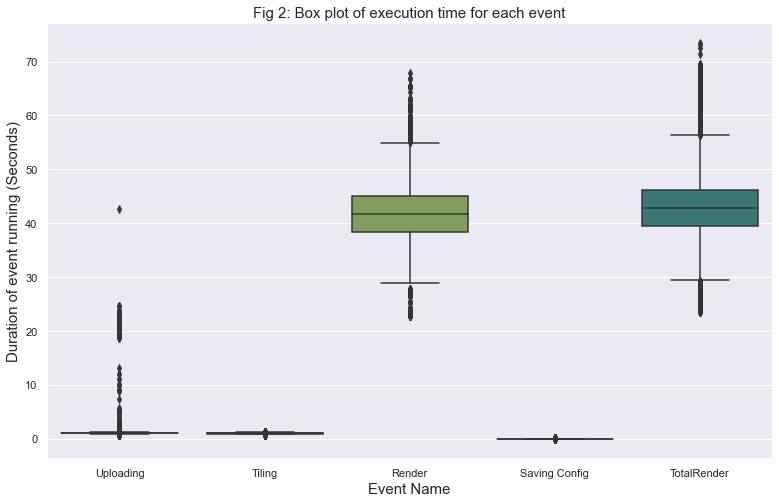

In [95]:
#ques 1

# Box plot for Events to analyse which event is taking most of the computation time...
fig, ax = plt.subplots(figsize=(13, 8))
sns.boxplot(x="eventName", y="duration", data=df, ax=ax)
sns.set(font_scale = 1.1)
sns.set_theme(style="darkgrid", palette = 'gist_earth_r')
ax.set_xlabel('Event Name', fontsize = 15)
ax.set_ylabel('Duration of event running (Seconds)', fontsize = 15)
ax.set_title("Fig 2: Box plot of execution time for each event", fontsize = 15)
plt.show()

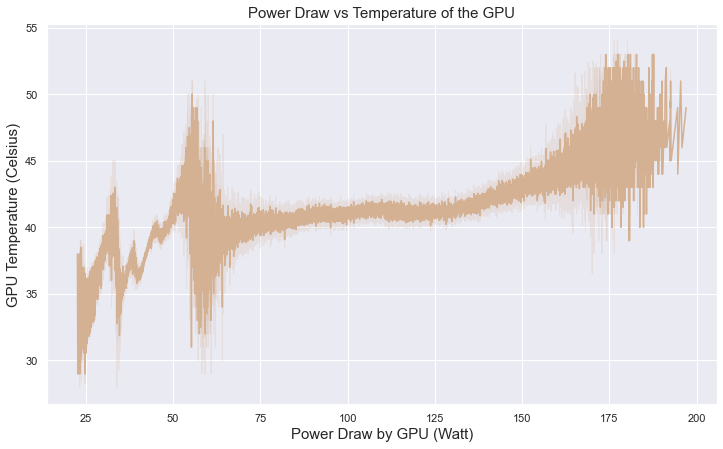

In [96]:
#ques 2



# Line plot to show relation between power draw (performance) and GPU temperature...
fig, ax = plt.subplots(figsize=(12, 7)) 
ax = sns.lineplot(data=gpudf, x="powerDrawWatt", y="gpuTempC")
plt.xlabel('Power Draw by GPU (Watt)', fontsize = 15)
plt.ylabel('GPU Temperature (Celsius)', fontsize = 15)
plt.title("Power Draw vs Temperature of the GPU", fontsize = 15)
plt.show()


In [101]:
#mazze ke liye for abstract

render_data = app_task_gpu_df[app_task_gpu_df['eventName'] != 'TotalRender']
avg_data = render_data[['gpuSerial', 'eventName', 'gpuTempC', 'gpuUtilPerc', 'gpuMemUtilPerc', 'powerDrawWatt']].groupby(['gpuSerial','eventName']).mean()
avg_data.reset_index(inplace=True)


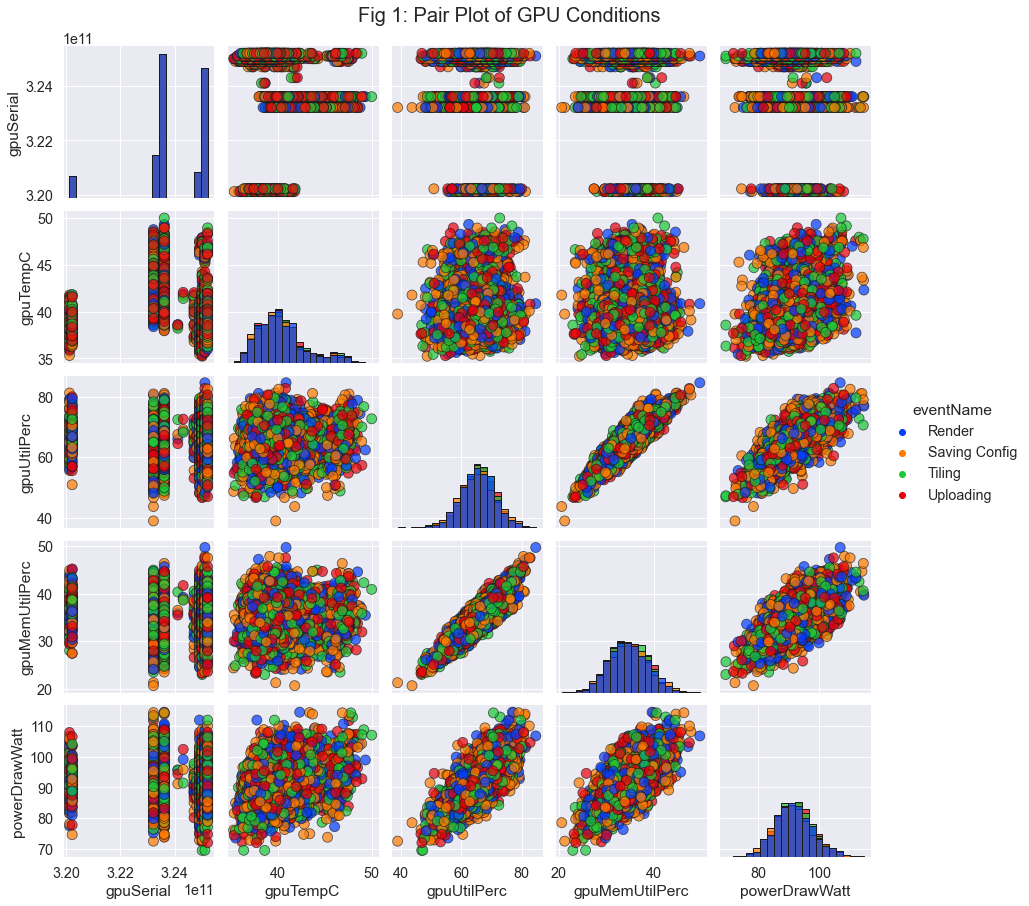

In [155]:


# Pairplot of averaged data to see relationship between various GPU conditions.

# sns.set(font_scale = 1.5)
# f = sns.pairplot(avg_data, hue="eventName", diag_kind='hist',
#                  diag_kws=dict(bins=20, edgecolor="k", linewidth=1,alpha=0.7),
#                  plot_kws=dict(s=100, alpha=0.7, edgecolor="k"))
# f.fig.suptitle("Fig 1: Pair Plot of GPU Conditions", fontsize = 20, y=1.01)
# plt.xticks(rotation=45)
# plt.show()

sns.set(font_scale = 1.3, rc={'figure.figsize':(15, 10)})
f = sns.pairplot(avg_data, hue="eventName", diag_kind='hist',
                 diag_kws=dict(bins=20, edgecolor="k", linewidth=1,alpha=0.7),
                 plot_kws=dict(s=100, alpha=0.7, edgecolor="k"),palette='bright')
f.fig.suptitle("Fig 1: Pair Plot of GPU Conditions", fontsize = 20, y=1.01)
plt.xticks(rotation=45)
plt.show()


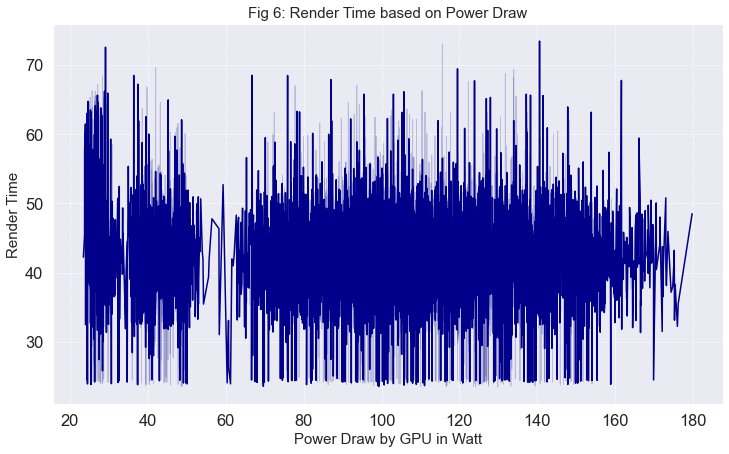

In [127]:
#ques 3



# line plot of render time against power draw...
fig, ax = plt.subplots(figsize=(12, 7))
ax = sns.lineplot(data=df.query("eventName == 'TotalRender'"), x="powerDrawWatt_y", y="duration", 
                  markers=True, dashes=False, color='darkblue')
ax.set_xlabel('Power Draw by GPU in Watt', fontsize = 15)
ax.set_ylabel('Render Time', fontsize = 15)
ax.set_title("Fig 6: Render Time based on Power Draw", fontsize = 15)
ax.grid(True, linestyle='--', alpha=0.7)
plt.show()



In [129]:
# #ques 4

# gpu['gpuSerial'] = gpu['gpuSerial'].astype(str) # Coverting gpuSerial to string from int...

# # making a new dataframe with only gpuSerial and powerDrawWatt... 
# # and finding the mean of powerDrawWatt by grouping on gpuSerial...
# gpu_powerdraw = gpu[['gpuSerial', 'powerDrawWatt']].groupby(['gpuSerial']).mean() 

# gpu_powerdraw.index.names = ['gpuSerial'] # Changing index of dataframe to column...
# gpu_powerdraw.reset_index(inplace=True) # Resetting the index of the dataframe...


gpudf['gpuSerial'] = gpudf['gpuSerial'].astype(str)

gpu_powerdraw = gpudf.groupby('gpuSerial', as_index=False)['powerDrawWatt'].mean()

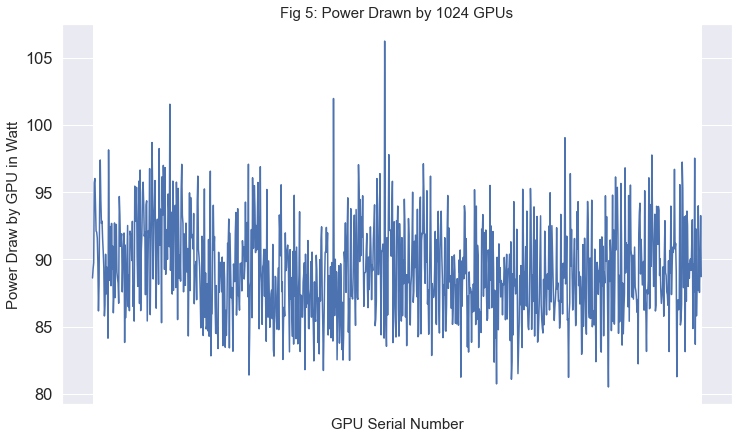

In [135]:


# line plot of power draw against serial number of the gpu...
fig, ax = plt.subplots(figsize=(12, 7))
sns.set_style("darkgrid")
plot = sns.lineplot(data = gpu_powerdraw, x="gpuSerial", y="powerDrawWatt", ax=ax)
plt.xlabel('GPU Serial Number', fontsize = 15)
plt.ylabel('Power Draw by GPU in Watt', fontsize = 15)
plt.title("Fig 5: Power Drawn by 1024 GPUs", fontsize = 15)
plot.set(xticklabels=[])
plt.show()



In [160]:
# gpu tables

gpu_powerdraw = gpu_powerdraw.sort_values(by = 'powerDrawWatt') # Sorting by powerDrawWatt...
print("Low Performing GPUs")
df_low = gpu_powerdraw.head(5)
df_low

Low Performing GPUs


,gpuSerial,powerDrawWatt
867,325117171574,80.510313
679,325017017790,80.742673
704,325017018552,81.087075
800,325017049295,81.226755
619,324917052619,81.242179


In [162]:
print("High Performing GPUs")
df_high = gpu_powerdraw.tail()
df_high


High Performing GPUs


,gpuSerial,powerDrawWatt
100,323217056123,98.698678
794,325017049041,99.057575
130,323217056368,101.549633
405,323617021202,101.974324
491,323617042596,106.247462


In [163]:
df_gpu_min_max = pd.concat([df_low, df_high])
df_gpu_min_max

,gpuSerial,powerDrawWatt
867,325117171574,80.510313
679,325017017790,80.742673
704,325017018552,81.087075
800,325017049295,81.226755
619,324917052619,81.242179
100,323217056123,98.698678
794,325017049041,99.057575
130,323217056368,101.549633
405,323617021202,101.974324
491,323617042596,106.247462


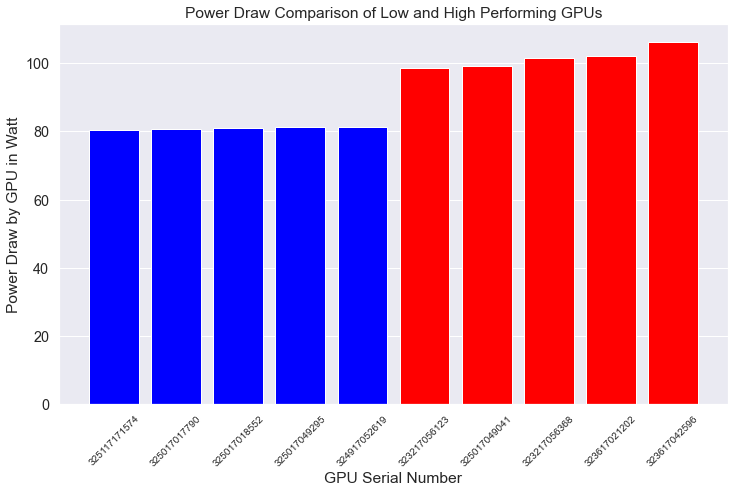

In [173]:
#plot a graph from above tables

# Set the x-axis to be the GPU serial number
x = df_gpu_min_max['gpuSerial']

# Set the y-axis to be the power draw in watts
y = df_gpu_min_max['powerDrawWatt']

# Create a new figure and axis
fig, ax = plt.subplots(figsize=(12, 7))

# Plot the low-performing GPUs as blue bars
ax.bar(x[:5], y[:5], color='blue')

# Plot the high-performing GPUs as red bars
ax.bar(x[5:], y[5:], color='red')

# Label the x and y axes
ax.set_xlabel('GPU Serial Number')
ax.set_ylabel('Power Draw by GPU in Watt')

# Add a title to the plot
ax.set_title('Power Draw Comparison of Low and High Performing GPUs')

ax.yaxis.grid(True)
ax.xaxis.grid(False)

# Rotate the x-axis labels by 45 degrees
plt.xticks(rotation=45)

# Reduce the font size of the x-axis labels
plt.tick_params(axis='x', labelsize=10)
# Show the plot
plt.show()


In [ ]:
#reflection and #conclusion